In [1]:
# Importing neccesary libraries for the project:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
online = pd.read_csv('online_data.csv')

In [4]:
online.head()

,InvoiceNo,StockCode,InvoiceDate,CustomerID,Quantity,UnitPrice
0,572558,22745,2011-10-25 08:26:00,14286,2,1740
1,577485,23196,2011-11-20 11:56:00,16360,2,3177
2,560034,23299,2011-07-14 13:35:00,13933,2,3429
3,578307,72349B,2011-11-23 15:53:00,17290,1,2298
4,554656,21756,2011-05-25 13:36:00,17663,3,1388


In [5]:
#Conversion of dtype of InvoiceDate column from 'object' to 'datetime' type for better date/time manipulations:
online.InvoiceDate = pd.to_datetime(online.InvoiceDate)

In [6]:
#Calculating Total Sum amount in each transaction
online['TotalSum'] = online.Quantity * online.UnitPrice

In [7]:
online.head()

,InvoiceNo,StockCode,InvoiceDate,CustomerID,Quantity,UnitPrice,TotalSum
0,572558,22745,2011-10-25 08:26:00,14286,2,1740,3480
1,577485,23196,2011-11-20 11:56:00,16360,2,3177,6354
2,560034,23299,2011-07-14 13:35:00,13933,2,3429,6858
3,578307,72349B,2011-11-23 15:53:00,17290,1,2298,2298
4,554656,21756,2011-05-25 13:36:00,17663,3,1388,4164


In [8]:
# creating a hypothetical snapshot_day data as if we're doing analysis recently.
snapshot_date = max(online.InvoiceDate) + datetime.timedelta(days=1)

In [9]:
# Aggregating data on a customer level
datamart = online.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                               'InvoiceNo': 'count',
                                               'TotalSum': 'sum'})

# Renaming columns for easier interpretation
datamart.rename(columns = {'InvoiceDate': 'Recency',
                           'InvoiceNo': 'Frequency',
                           'TotalSum': 'MonetaryValue'}, inplace=True)

# Checking the first 5 rows:
datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,27,121712
12748,1,967,5625961
12749,4,37,277003
12820,3,17,114433
12822,71,9,59892


In [10]:
datamart_rfm = datamart.copy()

In [11]:
datamart_rfm.describe()

,Recency,Frequency,MonetaryValue
count,3701.000000,3701.000000,3.701000e+03
mean,94.298568,19.147257,1.145839e+05
std,99.974969,44.831615,2.680117e+05
min,1.000000,1.000000,1.013000e+03
25%,19.000000,4.000000,2.211200e+04
50%,52.000000,9.000000,5.358200e+04
75%,151.000000,21.000000,1.255550e+05
max,374.000000,1532.000000,9.117712e+06


# Exploring distribution of Recency

C:\Users\amank\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


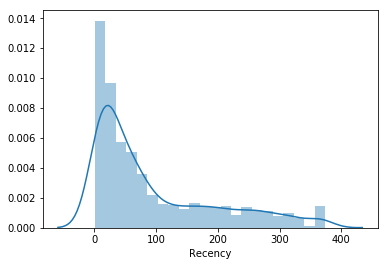

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.distplot(datamart['Recency'])
plt.show()

# Exploring distribution of Frequency

C:\Users\amank\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


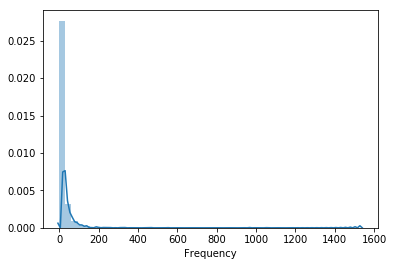

In [13]:
sns.distplot(datamart['Frequency'])
plt.show()

# Data transformations to manage skewness found above

Logarithmic transformation

C:\Users\amank\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


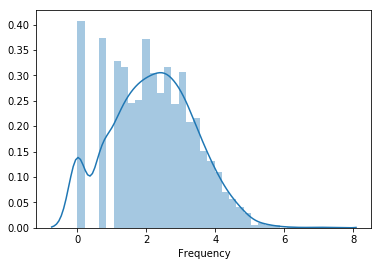

In [15]:
import numpy as np
frequency_log= np.log(datamart['Frequency'])
sns.distplot(frequency_log)
plt.show()

# Identifying an issue

The mean & standard deviation of Recency, Frequency & Monetary Value are not on same scale & differing from each other in a very high range ; which is violating the assumption of KMeans to be applied. So, we'll be using Standard Scaling to bring the mean & standard deviation of all into 1 standard scale.

In [16]:
datamart_rfm.describe()

,Recency,Frequency,MonetaryValue
count,3701.000000,3701.000000,3.701000e+03
mean,94.298568,19.147257,1.145839e+05
std,99.974969,44.831615,2.680117e+05
min,1.000000,1.000000,1.013000e+03
25%,19.000000,4.000000,2.211200e+04
50%,52.000000,9.000000,5.358200e+04
75%,151.000000,21.000000,1.255550e+05
max,374.000000,1532.000000,9.117712e+06


# Centering variables with different means

In [17]:
datamart.mean()

Recency              94.298568
Frequency            19.147257
MonetaryValue    114583.909754
dtype: float64

In [18]:
# Centering mean is done by subtracting average value from each observation:
datamart_centered = datamart_rfm - datamart_rfm.mean()
datamart_centered.describe().round(2)

,Recency,Frequency,MonetaryValue
count,3701.00,3701.00,3701.00
mean,0.00,0.00,-0.00
std,99.97,44.83,268011.74
min,-93.30,-18.15,-113570.91
25%,-75.30,-15.15,-92471.91
50%,-42.30,-10.15,-61001.91
75%,56.70,1.85,10971.09
max,279.70,1512.85,9003128.09


# Scaling variables with different variance

In [19]:
# Scaling Standard deviation is done by dividing them by standard deviation of each: 
datamart_scaled = datamart_rfm / datamart_rfm.std()
datamart_scaled.describe().round(2)

,Recency,Frequency,MonetaryValue
count,3701.00,3701.00,3701.00
mean,0.94,0.43,0.43
std,1.00,1.00,1.00
min,0.01,0.02,0.00
25%,0.19,0.09,0.08
50%,0.52,0.20,0.20
75%,1.51,0.47,0.47
max,3.74,34.17,34.02


# Combining centering and scaling

#Way 1 : Subtracting mean and divide by standard deviation manually

#Way 2 : Using a scaler from scikit-learn library (returns numpy.ndarray object)

In [20]:
# we shall be using StandardScaler from scikit-learn:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(datamart_rfm)
datamart_normalized = scaler.transform(datamart_rfm)

In [21]:
print('mean: ', datamart_normalized.mean(axis=0).round(2))
print('std: ', datamart_normalized.std(axis=0).round(2))

mean:  [-0.  0. -0.]
std:  [1. 1. 1.]
